This notebook is intended as a companion to the paper "Robust inference of neutron-star parameters from thermonuclear burst observations" by D. K. Galloway et al., and includes simple examples of using methods as part of the `concord` repository to demonstrate the inference of neutron star properties & burst fuel composition from observations and comparison with simulated data. 

The sections below largely follow the discussion in the paper, and include examples of data analysis from 
1. IGR J00291+5934
1. XMMU J181227.8-181234 (= XTE J1812-182)
1. SAX J1810.8-2609
1. IGR J17591-2342

The analysis approaches are broken into cases where you have 0, 1, 2 or more bursts; and for 2 or more, you can divide further into cases where you have no adjacent bursts, but can estimate an average recurrence time (e.g. in the case of XMMU J181227.8-181234; goodwin19b). See below for these examples

### Future work

* Add in a routine to do the distance estimate as for XMMU J181227.8-181234, where you compare the mdot implied by the burst recurrence time to the persistent flux

### Modification history

`hfrac` has been further updated to calculate the H-fraction even when the hydrogen is exhausted at the base

The `hfrac` function and the results have been updated for the new $Q_{\rm nuc}$ coefficients derived by Adelle on 25/6/18

### Functions

Here we define the routine(s) that do the heavy lifting; as of 2019 Aug these have been incorporated into `concord`

```
Q_nuc
hfrac
iso_dist
dist
mdot
yign
L_Edd
```

In [1]:
import concord as cd
import astropy.constants as const
import matplotlib.pyplot as plt
from scipy.stats import poisson

from chainconsumer import ChainConsumer
from numpy.random import normal, multivariate_normal

%matplotlib inline

flux_unit = u.erg/u.cm**2/u.s
mdot_Edd = 8.8e4*u.g/u.cm**2/u.s

## Zero bursts

Here we compare the results from a study of the accretion-powered millisecond pulsar IGR J00291+5934, as published in gal06b; along with pointers to Adelle's version of settle. Can compare the earlier work with the subsequent detection of a burst from the source [kuin15](http://www.astronomerstelegram.org/?read=7849), with distance derivation

1.0 0.25881904510252074
0.9271838545667874 0.848048096156426
Distance range including inclination constraints is 5.00_-0.48^0.66 kpc
  incorporates model-predicted anisotropy averaging xi_b = 0.704
0.5004


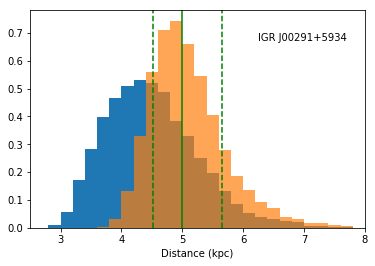

In [2]:
src = 'IGR J00291+5934'
F_pk, F_pk_err = 18, 4 # 1e-8 erg/cm^2/s; 

F_pk *= 1e-8*flux_unit
F_pk_err *= 1e-8*flux_unit

# Generate the distance distributions based on the peak flux, and the
# empirical Eddington luminosity; two options here, the first with no
# constraints on the inclination, the second imposing the inferred
# inclination range of torres08, of 22-32 degrees

dist_all = cd.dist(F_pk, F_pk_err, empirical=True, fulldist=True)
dist = cd.dist(F_pk, F_pk_err, empirical=True, fulldist=True, imin=22, imax=32)#, plot=True)

# Display the best estimate of the plausible range

dper = np.percentile(dist['dist'],(50,16,84))
print ('''Distance range including inclination constraints is {:.2f}_{:.2f}^{:.2f} kpc
  incorporates model-predicted anisotropy averaging xi_b = {:.3f}'''.format(
    dper[0],(dper[1]-dper[0]),dper[2]-dper[0],np.mean(dist['xi_b'])))
print (len(np.where(dist['dist'] > 5.*u.kpc)[0])/len(dist['dist']))

# Plot to compare the 2 distributions

fig1 = plt.figure()
plt.hist(dist_all['dist'].value,bins=np.arange(40)/5.,density=True)
plt.hist(dist['dist'].value,bins=np.arange(40)/5.,alpha=0.7,density=True)
plt.xlim(2.5,8)
plt.xlabel('Distance (kpc)')
plt.text(7.7, .67, src, horizontalalignment='right')

plt.axvline(dper[0],color='g')
plt.axvline(dper[1],color='g',ls='--')
plt.axvline(dper[2],color='g',ls='--')

# fig1.savefig("fig1.pdf", bbox_inches='tight')

## 1 burst

Here I follow through the analysis of the (single) burst from IGR J17591-2342, from Table 3 of Kuiper et al. 2020 (https://arxiv.org/abs/2002.12154)

In [3]:
src = 'IGR J17591-2342'
t0 = 58380.96358 # MJD
instr = 'IJ1'

F_pk, F_pk_err = 7.6, 1.4 # 1e-8 erg/cm^2/s
F_pers, F_pers_err = 1.2, 0.2 # 1e-9 erg/cm^2/s
E_b, E_b_err = 1.1, 0.1 # 1e-6 erg/cm^2

# Apply the units

F_pk *= 1e-8*flux_unit
F_pk_err *= 1e-8*flux_unit
F_pers *= 1e-9*flux_unit
F_pers_err *= 1e-9*flux_unit
E_b *= 1e-6*u.erg/u.cm**2
E_b_err *= 1e-6*u.erg/u.cm**2

0.9135454576426009 0.8660254037844387
Distance limits including inclination constraint 7.70_-0.62^+0.83 kpc (100000 samples);
  with burst anisotropy factor averaging xi_b = 0.70

Accretion rate implied from persistent flux, including xi_p = 0.47 is 1926.60_-419.63^+559.11 g / (cm2 s)
  or 0.022_-0.005^+0.006 cm2 s / g in units of the Eddington accretion rate


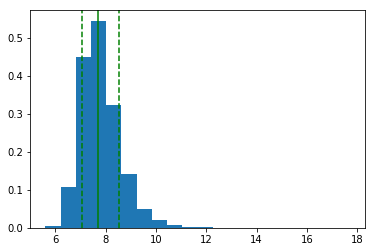

In [4]:
# There is a rough limit of 28-30 degrees for the inclination
# We can use that to constrain the various system parameters we've derived
# Use 100000 samples to make the figure for publication, with slightly smoother
# distributions

dist2 = cd.dist(F_pk, F_pk_err, empirical=True, fulldist=True, imin=24, imax=30)#, nsamp=100000)

plt.hist(dist2['dist'].value,density=True,bins=20)
dper = np.percentile(dist2['dist'],(50,16,84))
plt.axvline(dper[0],color='g')
plt.axvline(dper[1],color='g',ls='--')
plt.axvline(dper[2],color='g',ls='--')
# xiper = np.percentile(dist2['xi_b'][g],(50,16,84))

# These values for the paper

print ('''Distance limits including inclination constraint {:.2f}_{:.2f}^{:+.2f} kpc ({} samples);
  with burst anisotropy factor averaging xi_b = {:.2f}'''.format(
    dper[0], dper[1]-dper[0], dper[2]-dper[0], len(dist2['dist']),
    np.mean(dist2['xi_b'])))

# Estimate the accretion rate

m2 = cd.mdot(F_pers,F_pers_err,dist2['dist'],inclination=dist2['i'],fulldist=True)

mdot = np.percentile(m2['mdot'],(50,16,84))
print ('''
Accretion rate implied from persistent flux, including xi_p = {:.2f} is {:.2f}_{:.2f}^{:+.2f} {}
  or {:.3f}_{:.3f}^{:+.3f} in units of the Eddington accretion rate'''.format(
    np.mean(m2['xi_p']),mdot[0],mdot[1]-mdot[0],mdot[2]-mdot[0],m2['mdot'].unit,
          (mdot[0]/mdot_Edd).value,((mdot[1]-mdot[0])/mdot_Edd).value,(mdot[2]-mdot[0])/mdot_Edd))


Improved value including inclination constraints; 1928_424^557 g / (cm2 s)


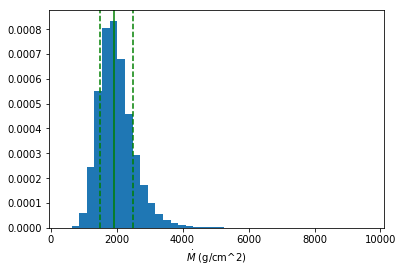

In [5]:
# More realistic calculation, propagating through the distance estimates, which include
# dependence on the inclination; now with the narrower range

m2 = cd.mdot(F_pers,F_pers_err,dist2['dist'],inclination=dist2['i'],fulldist=True)

m2_plot = plt.hist(m2['mdot'].value,bins=40,density=True)
plt.xlabel('$\dot{M}$ (g/cm^2)')
m, m16, m84 = np.percentile(m2['mdot'],[50,16,84])
print ('''
Improved value including inclination constraints; {:.0f}_{:.0f}^{:.0f} g / (cm2 s)'''.format(
        m,m-m16,m84-m))
plt.axvline(np.percentile(m2['mdot'],50),color='g')
plt.axvline(np.percentile(m2['mdot'],16),color='g',ls='--')
plt.axvline(np.percentile(m2['mdot'],84),color='g',ls='--')


Ignition column is 2.16_-0.80^+1.36 e8 g / cm2

Inferred recurrence time is 1.78 +/- 0.72 d


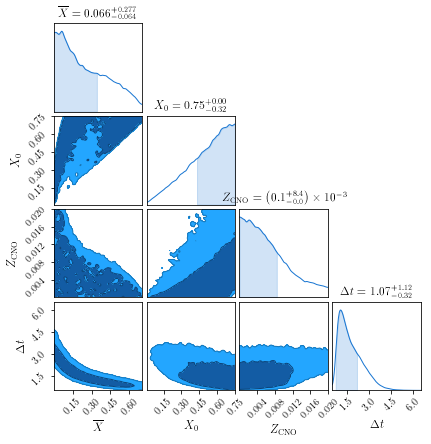

In [7]:
# This calculation determines the ignition column; in the absence of a value for Xbar, 
# a random distribution of values is used
# A uniform distribution of Xbar is not realistic, but it's hard to do better
# also, large values of Xbar are suppressed by the limit on X_0, down the track

nsamp = len(dist2['dist'])
Xbar = np.random.random(nsamp)*0.7

# Calculate the ignition column

y2 = cd.yign(E_b, E_b_err, dist2['dist'], inclination=dist2['i'], Xbar=Xbar, fulldist=True)

# Now the recurrence time

dt1 = y2['yign']/m2['mdot']*1.259

# The combination of Xbar and recurrence time constrain X_0 and Z_CNO. 
# For each pair, we calculate the values here

Z_CNO = np.random.random(nsamp)*0.02

x_0 = np.zeros(nsamp)
for i in range(nsamp):
    x_0[i] = cd.X_0(Xbar[i],Z_CNO[i],dt1[i].to('hr'))

# We restrict to physical values i.e. x_0 < 0.75

g = np.where(x_0 < 0.75)[0]

yign = np.percentile(y2['yign'][g]/1e8,(50,16,84))
print('''
Ignition column is {:.2f}_{:.2f}^{:+.2f} e8 {}'''.format(
    yign[0],yign[1]-yign[0],yign[2]-yign[0],y2['yign'].unit))

print('''
Inferred recurrence time is {:.2f} +/- {:.2f}'''.format(
    np.mean(dt1[g]).to('d').value,np.std(dt1).to('d')))

# using instead chainconsumer to plot; see 
# https://samreay.github.io/ChainConsumer/examples/customisations/plot_one_chain.html

data = np.vstack((Xbar[g], x_0[g], Z_CNO[g], dt1[g].to('day'))).T

# If you pass in parameter labels and only one chain, you can also get parameter bounds
fig = ChainConsumer().add_chain(data, 
                                parameters=["$\overline{X}$", "$X_0$", "$Z_\mathrm{CNO}$", "$\Delta t$"]).plotter.plot(
# uncomment the following line to save the plot
#                                filename='igrJ17591-2342.pdf'
                                )


## Older analysis below

done up to this point following along with the paper, 2020 May

Paper distance estimate for empirical Eddington flux, pure He;
  6.5 \pm 0.3 kpc, compared to my calculation 6.46 \pm 0.61 kpc
  (not sure why error seems to be a factor of 2 too small)
1.0 0.25881904510252074
Taking into account anisotropy (for all possible inclinations), 6.80_1.00^1.10 kpc
1.0 0.25881904510252074


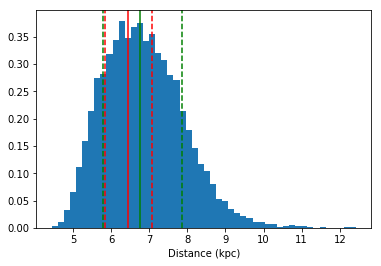

In [5]:
# This is the older analysis which replicate's Maurizio's original analysis

# Determine the distance; Maurizio gets 6.5 \pm 0.3 kpc (pure He)
# Compare what's in the curent paper draft

dhe0, dhe0_err = cd.dist(F_pk, F_pk_err, empirical=True, isotropic=True)
print ('''Paper distance estimate for empirical Eddington flux, pure He;
  6.5 \pm 0.3 kpc, compared to my calculation {:.2f} \pm {:.2f}
  (not sure why error seems to be a factor of 2 too small)'''.format( dhe0.value, dhe0_err ))

# A "better" estimate is as follows

dhe, dhe_err = cd.dist(F_pk, F_pk_err, empirical=True)
print ('Taking into account anisotropy (for all possible inclinations), {:.2f}_{:.2f}^{:.2f}'.format(
    dhe.value, -dhe_err[0].value, dhe_err[1]))

# And we now have a constraint on the inclination, 28-30 degrees, from Sanna et al;
# see the block below for those calculations

# ... and can get the full distribution like so

dist2 = cd.dist(F_pk, F_pk_err, empirical=True, fulldist=True, plot=True)
#print (len(dist2['dist']))
plt.axvline(dhe0.value,color='r')
plt.axvline((dhe0-dhe0_err).value,color='r',ls='--')
plt.axvline((dhe0+dhe0_err).value,color='r',ls='--')

# dist2['dist']

# Check the prefactor in the paper

# dist(3e-8*u.erg/u.cm**2/u.s, 0.0)

1.0 0.25881904510252074


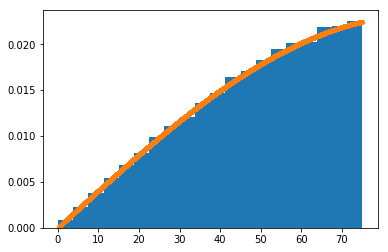

In [2]:
# Testing the idist function here

x = cd.iso_dist(nsamp=100000)
x.unit
plt.hist(x.value,bins=20,density=True)
plt.plot(x.value,np.sin(x.value/180.*np.pi)/43,'.')

0.17364817766693041 6.123233995736766e-17
Trying to replicate Hauke's latest analysis for the Eddington luminosity for 4U 0513-40
  Isotropic L_Edd = (2.82 \pm 0.32)e38 erg/s
  Including inclination constraints L_Edd = (4.96_-0.64^0.69)e38 erg/s


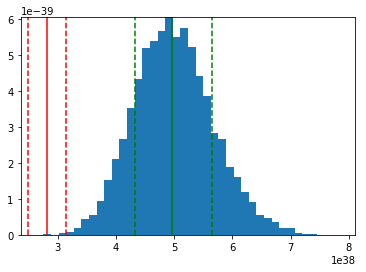

In [3]:
# Testing the L_Edd function with inclination limits

src ='4U 0513-40'
flux_unit = 1e-9*u.erg/u.cm**2/u.s
L_Edd1, L_Edd1_err = cd.L_Edd(22.2*flux_unit, 2.4*flux_unit, 10.3*u.kpc, 0.2*u.kpc, isotropic=True)
L_Edd2 = cd.L_Edd(22.2*flux_unit, 2.4*flux_unit, 10.3*u.kpc, 0.2*u.kpc, imin=80, imax=90, fulldist=True)

res = np.percentile(L_Edd2['L_Edd'],(50,16,84))/1e38
ledd_plot = plt.hist(L_Edd2['L_Edd'].value,bins=40,density=True)
plt.axvline(res[0]*1e38,color='g')
plt.axvline(res[1]*1e38,color='g',ls='--')
plt.axvline(res[2]*1e38,color='g',ls='--')
plt.axvline(L_Edd1.value,color='r')
plt.axvline((L_Edd1+L_Edd1_err).value,color='r',ls='--')
plt.axvline((L_Edd1-L_Edd1_err).value,color='r',ls='--')

print('''Trying to replicate Hauke's latest analysis for the Eddington luminosity for {}
  Isotropic L_Edd = ({:.2f} \pm {:.2f})e38 erg/s
  Including inclination constraints L_Edd = ({:.2f}_{:.2f}^{:.2f})e38 erg/s'''.format(src, 
                                            L_Edd1.value/1e38, L_Edd1_err.value/1e38,
                                            res[0],(res[1]-res[0]),res[2]-res[0]))

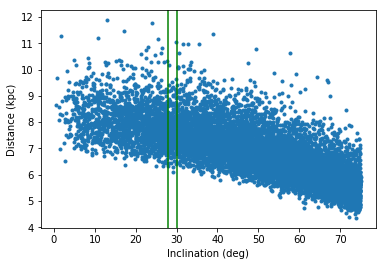

In [16]:
# Show here the relation between the inclination angle and the distance

plt.plot(dist2['i'],dist2['dist'],'.')
plt.xlabel('Inclination (deg)')
plt.ylabel('Distance (kpc)')
plt.axvline(28,color='g')
plt.axvline(30,color='g')

Paper ignition column estimate for d=6.5 kpc, He burning (Q_nuc = 1.60 MeV/nucleon):
  3.7E8 g/cm^2, compared to my (isotropic) calculation 3.70e+08 \pm 3.36e+07 g / cm2;
  or for H-burning, with Xbar set so that Q_nuc = 4.40 MeV/nucleon; 
  0.5E8 g/cm^2, compared to 1.34e+08 \pm 1.22e+07 g / cm2


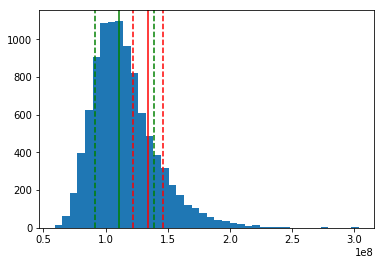

In [18]:
# Ignition column
# to get the same calculation as in the paper, we need to fudge the Xbar value to get
# Q_nuc = 4.4

Xbar = 0.5191
# print ("{} =? 4.4".format(1.31+6.95*Xbar-1.92*Xbar**2))
Xbar2 = 0.04222
# print ("{} =? 1.6".format(1.31+6.95*Xbar2-1.92*Xbar2**2))
       
yhe, yhe_err = cd.yign(E_b, E_b_err, 6.5*u.kpc, Xbar=Xbar2, isotropic=True)
yh, yh_err = cd.yign(E_b, E_b_err, 6.5*u.kpc, Xbar=Xbar, isotropic=True)
print ('''Paper ignition column estimate for d={} kpc, He burning (Q_nuc = {:.2f} MeV/nucleon):
  3.7E8 g/cm^2, compared to my (isotropic) calculation {:.2e} \pm {:.2e};
  or for H-burning, with Xbar set so that Q_nuc = {:.2f} MeV/nucleon; 
  0.5E8 g/cm^2, compared to {:.2e} \pm {:.2e}'''.format( 
    6.5, 1.31+6.95*Xbar2-1.92*Xbar2**2, yhe.value, yhe_err, 1.31+6.95*Xbar-1.92*Xbar**2, yh.value, yh_err ))

# For comparison, we here determine an updated version

y2 = cd.yign(E_b, E_b_err, dist2['dist'], inclination=dist2['i'], fulldist=True)
# print ("{:.3e}".format(y1))

y2_plot = plt.hist(y2['yign'].value,bins=40)
plt.axvline(np.percentile(y2['yign'],50),color='g')
plt.axvline(np.percentile(y2['yign'],16),color='g',ls='--')
plt.axvline(np.percentile(y2['yign'],84),color='g',ls='--')

plt.axvline(yh.value,color='r')
plt.axvline((yh-yh_err).value,color='r',ls='--')
plt.axvline((yh+yh_err).value,color='r',ls='--')

Recurrence times are 1.92 d and 0.70 d, respectively


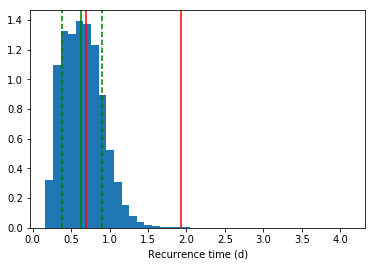

In [19]:
# Then can estimate recurrence time; first option follows the "naive" calculation

dt0_hi, dt0_lo = (yhe/m1*1.31).to('d'), (yh/m1*1.31).to('d')
print ("Recurrence times are {:.2f} and {:.2f}, respectively".format(
    dt0_hi, dt0_lo ))

# Now do a more robust one

dt1 = y2['yign']/m2['mdot']*1.31

plt.hist(dt1.to('d').value,bins=40,density=True)
plt.xlabel('Recurrence time (d)')
plt.axvline(np.percentile(dt1.to('d'),50),color='g')
plt.axvline(np.percentile(dt1.to('d'),16),color='g',ls='--')
plt.axvline(np.percentile(dt1.to('d'),84),color='g',ls='--')

plt.axvline(dt0_hi.value,color='r')#,ls='--')
plt.axvline(dt0_lo.value,color='r')#,ls='--')



[0.16500086 0.73060055]
[0.00049733 0.01677256]


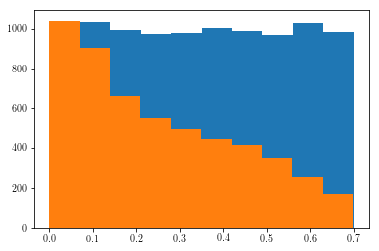

In [92]:
# plt.plot(x_0,Xbar,'.')
plt.hist(Xbar)
plt.hist(Xbar[g])

x95 = np.percentile(x_0[g],[5,95])
print (x95)
z95 = np.percentile(Z_CNO[g],[5,95])
print (z95)

## 2 (or more) bursts

See the example for XMMU J181227.8-181234 below. Here 6 bursts were observed over an exposure time of 0.3446 d, with many gaps in between. So we compute a distribution of mean recurrence times consistent with the measurements, and propagate this distribution through to the rest of the calculation

Assumed M_NS = 1.4 solMass, R_NS = 11.2000 km, 1+z = 1.2590, Z_CNO = 0.02
6.6739999999999995 4.446 9.470320000000001
Synthetic distribution of tdel has 1.378_-0.505^0.482 h
alpha = 574.85 (68% range 354.58-987.74)


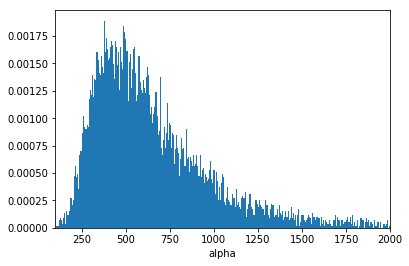

In [11]:
# Observations

exp = (0.3446*u.d).to('hr') # total exposure
nburst = 6 # total number of bursts observed (excluding SWT bursts)

fluen, fluene = 24.1, 7.3 # 1e-9 erg/cm^2
# fluen *= 2. # for testing
# fluene *=2.
# tdel, tdel_err = 1.38*u.hr, 0.56*u.hr
pflux, pfluxe = 1.19, 0.16 # 1e-9 erg/cm^2/s
bc = 2.522
f_unit = 1e-9*u.erg/u.cm**2

# Assumptions here

opz_def = cd.opz(1.4*const.M_sun,11.2*u.km)

xmax = 0.77
zcno_def = 0.02
# zcno_def = 0.05 # acceptance fraction up to 13%
nbin=10000

# some tests here

# opz_def*=1.1

z_def = opz_def-1.
print ("Assumed M_NS = {}, R_NS = {:.4f}, 1+z = {:.4f}, Z_CNO = {}".format(
#    M_NS,R_NS,1.+z_def,zcno_def))
    1.4*u.M_sun,11.2*u.km,1.+z_def,zcno_def))

# Estimate tdel and error based on Poisson stats

# Generate random iterates matching the cumulative distribution function

mu = np.arange(15000)/500. # [0-30]

prob = 1-poisson.cdf(nburst,mu)

x = np.random.random(nbin)
y = [mu[np.argmin(abs(prob-_x))] for _x in x]

# plt.hist(y)
tdel = exp/nburst

lim = np.percentile(y,(16,50,84))
print (lim[1],lim[0],lim[2])
print ('Synthetic distribution of tdel has {:.3f}_{:.3f}^{:.3f}'.format(
    tdel.value,(exp/lim[2]-tdel).value,exp/lim[0]-tdel))

# Draw nbin samples from the fluence and pflux distributions, consistent with the 
# estimated uncertainties

fluen = np.random.normal(loc=fluen, scale=fluene, size=nbin)
pflux = np.random.normal(loc=pflux, scale=pfluxe, size=nbin)
# tdel = exp/3.620
tdel = exp/y

# plt.hist(pflux,bins=20)

# Calculate alpha and plot the histogram

alpha = pflux*f_unit/u.s*bc*tdel.to('s')/(fluen*f_unit)
# print (np.isscalar(alpha))

plt.hist(alpha,bins=6000,density=True)
plt.xlabel('alpha')
plt.xlim(100,2000)
# print (len(alpha))
# print (np.isscalar(alpha[3]))

# Also show the statistics

print ("alpha = {:.2f} (68% range {:.2f}-{:.2f})".format(np.percentile(alpha,50),
                                                       np.percentile(alpha,16),
                                                       np.percentile(alpha,84)))

In [12]:
# print (len(alpha))

xbar, _x_0, i = cd.hfrac(alpha,tdel,1+z_def,zcno=zcno_def,isotropic=False)#,debug=True)

1.0 0.25881904510252074


Accepting 2.09% of samples
For assumed 1+z = 1.2590, Z_CNO = 0.020, X_0 = 0.0556_0.0249^0.1044 (< 0.1565 @ 95%)
i = 27.2_12.2^41.7
10000 10000 10000 10000 10000 10000 10000


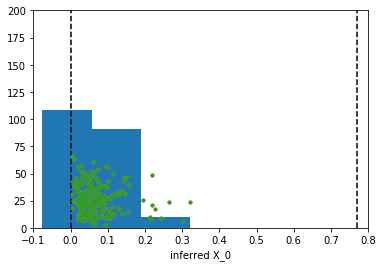

In [13]:
plt.hist(_x_0)
plt.xlim(-0.1,0.8)
plt.ylim(0,200)
plt.xlabel('inferred X_0')
plt.axvline(x=xmax,linestyle='--',color='k')
plt.axvline(x=0,linestyle='--',color='k')

good=np.logical_and(_x_0 <= xmax,_x_0 > 0)

# Stats on the accepted samples

print ("Accepting {}% of samples".format(
    100.*len(np.where(good)[0])/len(alpha)))

# Display results

print ("For assumed 1+z = {:.4f}, Z_CNO = {:.3f}, X_0 = {:.4f}_{:.4f}^{:.4f} (< {:.4f} @ 95%)".format(
    1+z_def,zcno_def,np.percentile(_x_0[good],50),
        np.percentile(_x_0[good],16),
        np.percentile(_x_0[good],84),
        np.percentile(_x_0[good],95)))
print ("i = {:.1f}_{:.1f}^{:.1f}".format(
    np.percentile(i[good],50),np.percentile(i[good],16),
       np.percentile(i[good],84)))



plt.plot(_x_0,i,'.')
plt.plot(_x_0[good],i[good],'.')

# Here we write out all the results

import pandas as pd

print (len(fluen),len(pflux),len(tdel),len(alpha),len(_x_0),len(i),len(xbar))
xi_p, xi_b = cd.diskmodel.anisotropy(i)

d = {'fluen': fluen, 'pflux': pflux, 'tdel': tdel, 'alpha': alpha,
     'xbar': xbar, 'x_0': _x_0, 'theta': i, 'xi_p': xi_p, 'xi_b': xi_b}

results = pd.DataFrame(data = d)
# plt.hist(results['alpha'],bins=100)
results.to_csv('1812-182_sim_results.csv')

## 2 or more bursts, individual measurements

Here's another example to get the column for bursts from XTE J1814-338. In this case we have multiple measurements of the recurrence time, alpha, and fluence, from MINBAR

Distance is unknown but the most energetic burst seen by _RXTE_ has spectral variations suggesting radius expansion; stroh03a used this to estimate the distance.

wang17a constrained the inclination to between 35-78 degrees

In [78]:
src = 'XTE J1814-338'

# MINBAR data:
# 3092 & 3099 are candidate short-recurrence time bursts, substantially weaker than the others
# so omit these from the analysis for now
data = np.array([# [3092, 2.325, 2.326,56.732, 1.541, 0.129, 0.002], 
                 [3095, 6.728, 6.728,89.274, 2.088, 0.248, 0.003],
                 # [3099, 1.692, 1.692,78.620, 7.198, 0.072, 0.006],
                 [3103, 6.878, 6.879,81.148, 3.884, 0.276, 0.006],
                 [3107, 6.961,13.921,90.715, 5.015, 0.252, 0.004],
                 [3109, 4.553, 4.554,52.849, 1.454, 0.270, 0.005]])

minbar = pd.DataFrame(data[0:,1:], index=data[0:,0], 
                      columns=['trec','tdel','alpha','alpha_err','bfluen','bfluene'])
minbar


,trec,tdel,alpha,alpha_err,bfluen,bfluene
3095.0,6.728,6.728,89.274,2.088,0.248,0.003
3103.0,6.878,6.879,81.148,3.884,0.276,0.006
3107.0,6.961,13.921,90.715,5.015,0.252,0.004
3109.0,4.553,4.554,52.849,1.454,0.270,0.005


In [79]:
fluen, fluene = np.mean(minbar['bfluen']), np.std(minbar['bfluen']) # 1e-6 erg/cm^2
pflux_pre, pflux_pre_e = 23.09, 1.38 # 1e-9 erg/cm^2/s
f_unit = 1e-9*u.erg/u.cm**2/u.s


In [80]:
xbar, _x_0, i = cd.hfrac(minbar['alpha'].values,minbar['tdel'].values*u.hr,isotropic=False)
print (xbar, _x_0, i)

# Calculate the distance; replicating stroh03a

d, d_err = cd.dist(pflux_pre*f_unit, pflux_pre_e*f_unit, empirical=False, X=0.7, isotropic=True)

# Perhaps more realistic

d = cd.dist(pflux_pre*f_unit, pflux_pre_e*f_unit, empirical=True, imin=35, imax=78, fulldist=True)
# print (d,d_err)

1.0 0.25881904510252074
[-0.01877318  0.26101496  0.43776537  0.11973681] [-1.          0.45615283  0.83266495  0.24874162] [74.434091   55.74161885 27.14538996 74.51927755] deg
0.8191520442889918 0.20791169081775945


In [81]:
yh, yh_err = cd.yign(fluen*1e-6*u.erg/u.cm**2, fluene*1e-6*u.erg/u.cm**2, 
                     d['dist'], inclination=d['i'], Xbar=0.3)
print ("{:.3f}_{:+.3f}^{:+.3f} \\times 10^7 g/cm^2".format(yh.value/1e7, yh_err[0].value/1e7, yh_err[1].value/1e7))

14.148_-0.996^+1.093 \times 10^7 g/cm^2


# Xbar runs
Zac incorporated Adelle's runs with measured Xbar into his grids (roughly), and the code below (copied from the "Burst matching" notebook) sets the paths and reads in an example file.

With these files we can create simulated bursts and then check the inferred Xbar with that measured from the Kepler results

In [3]:
from astropy.io import ascii

# Tried to import the modules, but there were too many unmet dependencies
# and other Zac-specific settings

# from pygrids.grid_analyser import grid_analyser

# Instead just read the summary and parameter files and read directly

# path='kepler_grids/sources/gs1826'
path = '/Users/Shared/data/kepler_grids/sources/adelle'
# data = ascii.read(path+'/summ_gs1826.txt')
data = ascii.read(path+'/summ/summ_adelle.txt')
# type(data)
# print (data.columns)

# Show cut through grid

# plt.plot(data['h'],data['z'],'.')

# param = ascii.read(path+'/params_gs1826.txt')
param = ascii.read(path+'/params/params_adelle.txt')
print (param.columns)
print ("Mass values: ",set(param['mass']))

# Show a different cut through the grid

plt.plot(param['mass'],param['accrate'],'.')
# Show histogram of mass values
# print ("Accretion rate values: ",set(param['accrate']*param['xi']))
print ("Q_b values: ",set(param['qb']))

# plt.hist(param['mass'],bins=[1.35,1.45,1.55,1.65,1.75,1.85,1.95,2.05])
# plt.ylim(0,10)

<TableColumns names=('batch','qb','x','accrate','mass','num','run','xbar','xbar_std','xign','y','z','tshift','xi','qb_delay','lburn','qnuc')>
Mass values:  {1.4}


NameError: name 'plt' is not defined

/Users/Shared/data/kepler_grids/sources/adelle mean_lightcurves/adelle_1/adelle_1_run5_mean.data
[4]
batch run     tDel      uTDel   lAcc  z    h 
----- --- ----------- --------- ---- ---- ---
    1   5 3500.726085 88.085026  0.3 0.02 0.6
batch run accrate   xbar   mass  z  
----- --- ------- -------- ---- ----
    1   5     0.3 0.562868  1.4 0.02
** WARNING ** insufficient parameters defined to convert to observed frame
1.305717832582133


AttributeError: 'KeplerBurst' object has no attribute 'print'

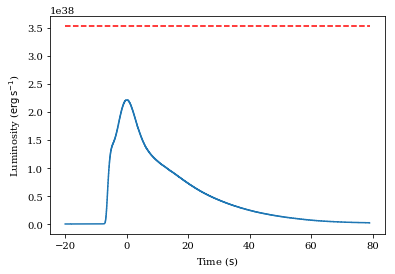

In [40]:
# Specify the model run by the batch and run number

batch=1
run=5

# slightly different filename convention here

filename='mean_lightcurves/adelle_{}/adelle_{}_run{}_mean.data'.format(
    batch,batch,run)
# filename='/mean_lightcurves/adelle_{}/'.format(batch)+filename
print (path,filename)

# lc = ascii.read(path+'/mean_lightcurves/adelle_{}/'.format(batch)+filename)
# print (lc.columns)

# Extract the corresponding model values from the table

# row=np.where(data['batch'] == 2 & data['run'] == 9)[0]
row=np.where(np.logical_and(data['batch'] == batch,data['run'] == run))[0]
prow=np.where(np.logical_and(param['batch'] == batch,param['run'] == run))[0]

# data[rows]
# print (data.columns, param.columns)
print (row)
print (data[row][['batch','run','tDel','uTDel','lAcc','z','h']])
print (param[prow][['batch','run','accrate','xbar','mass','z']])
# row=np.flatnonzero(data['batch'] == 2 & data['run'] == 9)[0]
# row
# data[row]

g = cd.g(param[prow]['mass']*const.M_sun,10*u.km)
opz = cd.opz(param[prow]['mass']*const.M_sun,10*u.km)
xbar5 = cd.KeplerBurst(filename,path=path,lAcc=data[row]['lAcc'],
                    Z=data[row]['z'],H=data[row]['h'],
                    tdel=data[row]['tDel']/opz,tdel_err=data[row]['uTDel']/opz,
                    g=g, opz=opz)
print (opz)
xbar5.plot()
xbar5.print()
# plt.plot(lc['time'],lc['luminosity'])

# Inferring Xbar
As a preliminary test, we use the set of "xbar" runs as for the paper, which have a measured Xbar (mean H-fraction at ignition).

These data can be found in the local directory concord/kepler

Lightcurve files seem to be some binary format, I don't know how to read them. Asked Adelle (8/10/18)

In [42]:
xbar_path = 'kepler/xbar-runs/'
xbar_table = ascii.read(xbar_path+'allruns_attribs.txt')

print ("Got {} runs listed in summary file".format(len(xbar_table)))

xbar_table

# Pick a random one and try to read in the file

dir='run{}'.format(floor(xbar_table['runid'][13]))
lc = xbar_path+dir+'/'+dir+'.lc'
print (lc)

Got 60 runs listed in summary file
kepler/xbar-runs/run14/run14.lc


## Simulated data
The simulated data have been created with the "Burst Matching" notebook; first we read in the tables corresponding to the observed properties, as well as the "secret" table (including the input simulation parameters)

Key columns are below:
* (tdel, tdel_err) = data['col3'], data['col4']
* (fper, fper_err) = data['col5'], data['col6']
* bc = data['col7']
* Z_CNO = data_secret['col5']
* X_0 = data_secret['col7']
* i = data_secret['col16']
* 1+z = data_secret['col17']

In [26]:
path='sim10'
data = ascii.read(path+'/sim_info.csv')
data_secret = ascii.read(path+'_secret.csv')

# data_secret
data

col1,col2,col3,col4,col5,col6,col7
int64,int64,float64,float64,float64,float64,float64
0,0,2.4473,0.0504,1.2633e-09,6e-12,1.806
0,1,2.7985,0.0591,1.0983e-09,6e-12,1.806
0,2,3.7056,0.0729,8.1417e-10,6e-12,1.806
1,0,2.7538,0.0831,3.8215e-10,6e-12,1.806
1,1,3.1466,0.0841,3.3222e-10,6e-12,1.806
1,2,4.3953,0.1557,2.4629e-10,6e-12,1.806
2,0,2.3926,0.0383,5.1541e-09,6e-12,1.806
2,1,2.7309,0.0504,4.4807e-09,6e-12,1.806
2,2,3.6777,0.0857,3.3217e-09,6e-12,1.806


Here's a test of the new routine, for one row

In [14]:
# Assumptions here

opz_def = cd.opz(1.4*const.M_sun,11.2*u.km)
z_def = opz_def-1.
zcno_def = 0.02

print ("Assumed M_NS = {}, R_NS = {:.4f}, 1+z = {:.4f}, Z_CNO = {}".format(
#    M_NS,R_NS,1.+z_def,zcno_def))
    1.4*u.M_sun,11.2*u.km,1.+z_def,zcno_def))

Assumed M_NS = 1.4 solMass, R_NS = 11.2000 km, 1+z = 1.2590, Z_CNO = 0.02


<linfit.linfit.<locals>.Bunch object at 0x11393cf28>
** WARNING ** extrapolated fluence > stat_error, replacing
Fluence: 1.302e-06 erg / cm2, tdel: 2.77750 h, alpha: 19.1646, c_bol: 1.8060
Assumed M_NS = 1.4 solMass, R_NS = 11.2000 km, 1+z = 1.2590, Z_CNO = 0.02
Inferred x_0: 1.7770, actual: 0.6800
1000
Actual M_NS = 1.4 solMass, R_NS = 25.4474 km, 1+z = 1.0927, Z_CNO = 0.0075
Check x_0: 0.5900


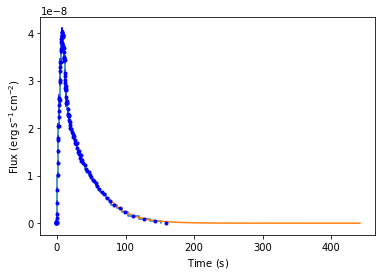

In [3]:
i=9

data['col1'][i]
b1 = ObservedBurst('sim{}_{}.csv'.format(data['col1'][i],data['col2'][i]),path=path)

# Extract all the observeables

fluen, fluene = b1.fluence(plot=True)
tdel = data['col3'][i]*u.hr
tdel_err = data['col4'][i]*u.hr
fper = data['col5'][i]*u.erg/u.cm**2/u.s
fper_err = data['col6'][i]*fper.unit
# Some question about whether the bolometric correction was correctly applied for the 
# persistent flux below
# Now resolved
c_bol = data['col7'][i]
# c_bol = 1.0
# Calculate derived quantities

alpha = tdel.to('s')*fper*c_bol/fluen
alpha_err = alpha*sqrt((tdel_err/tdel)**2+(fper_err/fper)**2
                       +(fluene/fluen)**2)

print ("Fluence: {:.4g}, tdel: {:.5f}, alpha: {:.4f}, c_bol: {:.4f}".format(
    fluen,tdel,alpha,c_bol))

# Need to calculate actual NS parameters from redshift (col17), mass
# (col13) and inclination (col16)

M_NS = data_secret['col13'][i]*u.M_sun
z_actual = data_secret['col17'][i]-1.
R_NS = (2*const.G*M_NS/const.c**2/(1.-1/(1.+z_actual)**2)).to('km')
# print (1.+z_actual," =? ",opz(M_NS,R_NS))
zcno_actual = data_secret['col5'][i]
inclination_actual = data_secret['col16'][i]*u.deg
# print (xi_b,xi_p,inclination_actual)

# Calculate the inferred value given the assumed redshift, and neglecting 
# anisotropy

xbar, x_0, i_True = hfrac(alpha,tdel,1+z_def,isotropic=True)

print ("Inferred x_0: {:.4f}, actual: {:.4f}".format(x_0,data_secret['col7'][i]))

# Try the statistical version

xbar, x_0, i_False = hfrac(alpha,tdel,1+z_def,isotropic=False)
print (len(xbar))
# plt.hist(x_0,bins=20)

# Calculate the actual value taking into account all the effects

print ("Actual M_NS = {}, R_NS = {:.4f}, 1+z = {:.4f}, Z_CNO = {}".format(
    M_NS,R_NS,1.+z_actual,zcno_actual))

# xbar_check = min([0.77,z_actual*alpha_0/alpha*(xi_b/xi_p)-0.96/6.6])
# print (xbar_check,xi_b,xi_p)
# x_0_check = min([0.77,xbar_check+0.35*(tdel/((1.+z_actual)*9.8*u.hr))*(zcno_actual/0.02)])
xbar_check, x_0_check, dummy = hfrac(alpha,tdel,opz=1+z_actual,zcno=zcno_actual,inclination=inclination_actual)
print ("Check x_0: {:.4f}".format(x_0_check))

Now loop over all the available simulated bursts and determine the h-fraction for each

In [4]:
xmax = 0.77

# specify how we want to treat the alpha values

alpha_dist = True
nsamp = 1000

# Set up the output lists

x_0_isotropic = []
x_0_best = []
x_0_actual = []
x_0 = []
x_0_err = []

# Now run the loop

for i in range(len(data)):

    data['col1'][i]
    b1 = ObservedBurst('sim{}_{}.csv'.format(data['col1'][i],data['col2'][i]),path=path)

# Extract all the observeables

    c_bol = data['col7'][i]
    fluen, fluene = b1.fluence()
    tdel = data['col3'][i]*u.hr
    tdel_err = data['col4'][i]*u.hr
    fper = data['col5'][i]*u.erg/u.cm**2/u.s
    fper_err = data['col6'][i]*fper.unit

# Calculate derived quantities

    if alpha_dist:
        alpha = ( np.random.normal(loc=tdel.to('s').value, scale=tdel_err.to('s').value, size=nsamp)
                  * np.random.normal(loc=fper.value, scale=fper_err.value, size=nsamp) * c_bol 
                  / np.random.normal(loc=fluen.value, scale=fluene.value, size=nsamp) )
    else:
        alpha = tdel.to('s')*fper*c_bol/fluen
        alpha_err = alpha*sqrt((tdel_err/tdel)**2+(fper_err/fper)**2
                       +(fluene/fluen)**2)

        print ("row {}: fluence: {:.4g}, tdel: {:.5f}, alpha: {:.4f}, c_bol: {:.4f}".format(
            i,fluen,tdel,alpha,c_bol))

# Generate values typical from earlier efforts to do this

    xbar, _x_0, dummy = hfrac(alpha,tdel,1+z_def,isotropic=True,old_relation=True)

    if alpha_dist:
        x_0_isotropic.append(min([xmax,np.percentile(_x_0,50)]))
    else:
        x_0_isotropic.append(min([xmax,_x_0]))
    x_0_actual.append(data_secret['col7'][i])

# Generate the best possible estimate

    xbar, _x_0, dummy = hfrac(alpha,tdel,data_secret['col17'][i],
                              zcno=data_secret['col5'][i],
                              isotropic=False,inclination=data_secret['col16'][i],
                              debug=True)
#    x_0_best.append(min([xmax,_x_0]))
    
    if alpha_dist:
        x_0_best.append(np.percentile(_x_0,50))
    else:
        x_0_best.append(_x_0)

# Generate more up-to-date (and hopefully more precise) estimates

    xbar, _x_0, dummy = hfrac(alpha,tdel,1+z_def,isotropic=False)
    good = np.where(_x_0 <= xmax)[0]
    if len(good) > 0:
        x_0.append(np.mean(_x_0[good]))
        x_0_err.append(0.5*(np.percentile(_x_0[good],84)
                            -np.percentile(_x_0[good],16)))
    else:
        x_0.append(xmax)
        x_0_err.append(0.0)

<linfit.linfit.<locals>.Bunch object at 0x11393cf98>
** WARNING ** extrapolated fluence > stat_error, replacing
hfrac: adopting 1000 samples to match size of alpha array
** WARNING ** assuming inclination in degrees
<linfit.linfit.<locals>.Bunch object at 0x113acbeb8>
** WARNING ** extrapolated fluence > stat_error, replacing
hfrac: adopting 1000 samples to match size of alpha array
** WARNING ** assuming inclination in degrees
<linfit.linfit.<locals>.Bunch object at 0x113abf3c8>
** WARNING ** extrapolated fluence > stat_error, replacing
hfrac: adopting 1000 samples to match size of alpha array
** WARNING ** assuming inclination in degrees
<linfit.linfit.<locals>.Bunch object at 0x1140509e8>
** WARNING ** extrapolated fluence > stat_error, replacing
hfrac: adopting 1000 samples to match size of alpha array
** WARNING ** assuming inclination in degrees
<linfit.linfit.<locals>.Bunch object at 0x113a14358>
** WARNING ** extrapolated fluence > stat_error, replacing
hfrac: adopting 1000 sam

What we find here typically is that the "best" value (using input 1+z, Z_CNO) overestimates the true value, while the isotropic value underestimates it.

The version incorporating a distribution of inclinations comes somewhere in the middle

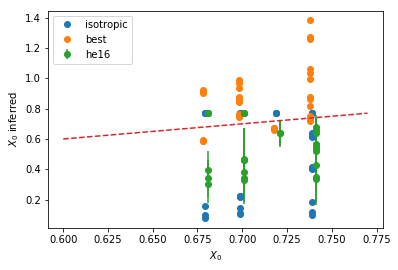

In [5]:
# poster size

# plt.figure(figsize=(10,8))

plt.plot(np.array(x_0_actual)-0.001,x_0_isotropic,"o",label='isotropic')
plt.plot(np.array(x_0_actual)-0.002,x_0_best,"o",label='best')
plt.errorbar(np.array(x_0_actual)+0.001,x_0,x_0_err,fmt="o",label='he16')

plt.plot([0.6,0.77],[0.6,0.77],'--')
plt.xlabel("$X_0$")
plt.ylabel("$X_0$ inferred")
plt.legend()

# plt.savefig('sim10_comparison.pdf')

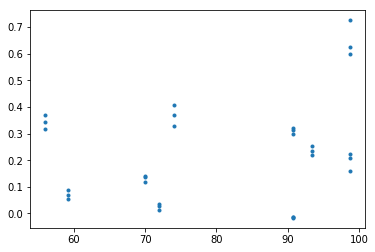

In [143]:
# Trying here to understand what gives the error we observe

# plt.hist(x_0_best-np.array(x_0_actual))
# plt.plot(data['col3']/data_secret['col17'],x_0_best-np.array(x_0_actual),'.')
plt.plot(data_secret['col7']/data_secret['col5'],x_0_best-np.array(x_0_actual),'.')

# XMMU J181227.8-181234 (= XTE J1812-182)

Here are some analysis results provided by Adelle on 14.6.18, approximate only; these were subsequently adopted in the submitted version of the paper (checked 22.2.19)

In [85]:
import astropy.stats as s

# Estimate tdel and error based on Poisson stats

exp = (0.3446*u.d).to('hr') # total exposure
nburst = 6 # total number of bursts observed (excluding SWT bursts)

# Use the function in astropy.stats

lim2 = s.poisson_conf_interval(nburst,interval='frequentist-confidence').T

print ('Best estimate of recurrence time is {:.2f}_{:.2f}^{:.2f}'.format(
    tdel.value,(exp/lim2[1]-tdel).value,exp/lim2[0]-tdel))

Best estimate of recurrence time is 1.38_-0.52^0.91 h


We run into a problem when we try to generate a synthetic distribution of recurrence times consistent with these limits, because the quoted limits given by both Gehrels et al. and the astropy.stats function poisson_conf_interval give the `n-1` value for the _lower_ limit (not sure why). I illustrate this below

0.9999998824909364


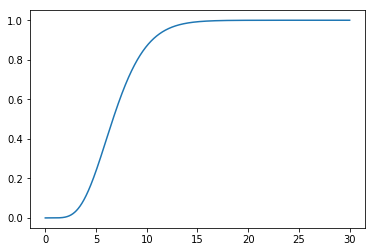

In [101]:
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html

mean = np.arange(15000)/500. # [0-30]

# This is the cumulative PDF for the mean rate, given the detection of nburst events

c = 1-poisson.cdf(nburst,mean)

# Now plot, for illustrative purposes

plt.plot(mean,c)
print (max(c))

In [102]:
# Now finding the 1-sigma confidence levels

conf = 0.8413*2.-1. # 1-sigma = 0.6826
# "double-sided intervals... can be obtained by substituting (1+cl)/2 for cl..." (gehrels86)
conf = (1+conf)/2.
print ('Adopting 1-sided confidence value of {:.4f}'.format(conf))

iup = np.argmin(abs(c-(1-conf)))
ilo = np.argmin(abs(c-conf))

print (iup,ilo,(1-conf),conf,mean[iup],mean[ilo])
print ('Compare with range in gehrels86 of (3.620,9.584)')

Adopting 1-sided confidence value of 0.8413
2209 4792 0.15869999999999995 0.8413 4.418 9.584
Compare with range in gehrels86 of (3.620,9.584)


So the cumulative distribution limits don't match what's returned by the `poisson_conf_interval` function (nor what's in Gehrels et al. 1986). We can go ahead anyway and generate a distribution matching our function, and then propagate it through to our xbar calculation

# SAX J1810.8-2609

Here we use some analysis of three bursts observed by RXTE, and calculate the inferred X_0

For assumed 1+z = 1.2590, X_0 = 0.5527_0.3580^0.7017
i = 53.7_41.4^66.4


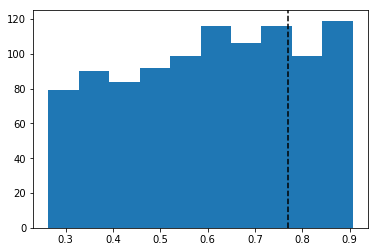

In [8]:
xbar, _x_0, i = hfrac(63.5,6.375*u.hr,1+z_def,isotropic=False)

plt.hist(_x_0)
plt.axvline(x=xmax,linestyle='--',color='k')

good=np.where(_x_0 <= xmax)[0]
print ("For assumed 1+z = {:.4f}, X_0 = {:.4f}_{:.4f}^{:.4f}".format(
    1+z_def,np.percentile(_x_0[good],50),np.percentile(_x_0[good],16),
       np.percentile(_x_0[good],84)))
print ("i = {:.1f}_{:.1f}^{:.1f}".format(
    np.percentile(i[good],50),np.percentile(i[good],16),
       np.percentile(i[good],84)))

